In [ ]:
!pip install kats
!pip install ruptures
!pip install pymannkendall

In [4]:
# Import the packages
import pandas as pd
import numpy as np
import pymannkendall as mk
import datetime as datetime
import plotly.express as px
from matplotlib import pyplot
from kats.consts import TimeSeriesData
from kats.detectors.outlier import OutlierDetector
from kats.detectors.seasonality import FFTDetector
from kats.detectors.robust_stat_detection import RobustStatDetector
from kats.utils.decomposition import TimeSeriesDecomposition
from kats.detectors.bocpd import BOCPDetector, BOCPDModelType, TrendChangeParameters
from kats.detectors.cusum_detection import CUSUMDetector

In [5]:
df = pd.read_excel('/content/drive/MyDrive/Github/m_tech/Datasets/input.xlsx')

In [6]:
df = df.dropna()  

In [7]:
df.tail()

,Date,SalesVolume
315,2021-04-01,66565
316,2021-05-01,56135
317,2021-06-01,103085
318,2021-07-01,21935
319,2021-08-01,26661


## **Decomposing the Series**

In [8]:
kats_df = df.rename(columns={'Date':'time', 'SalesVolume':'value'})

In [9]:
ts = TimeSeriesData(kats_df)

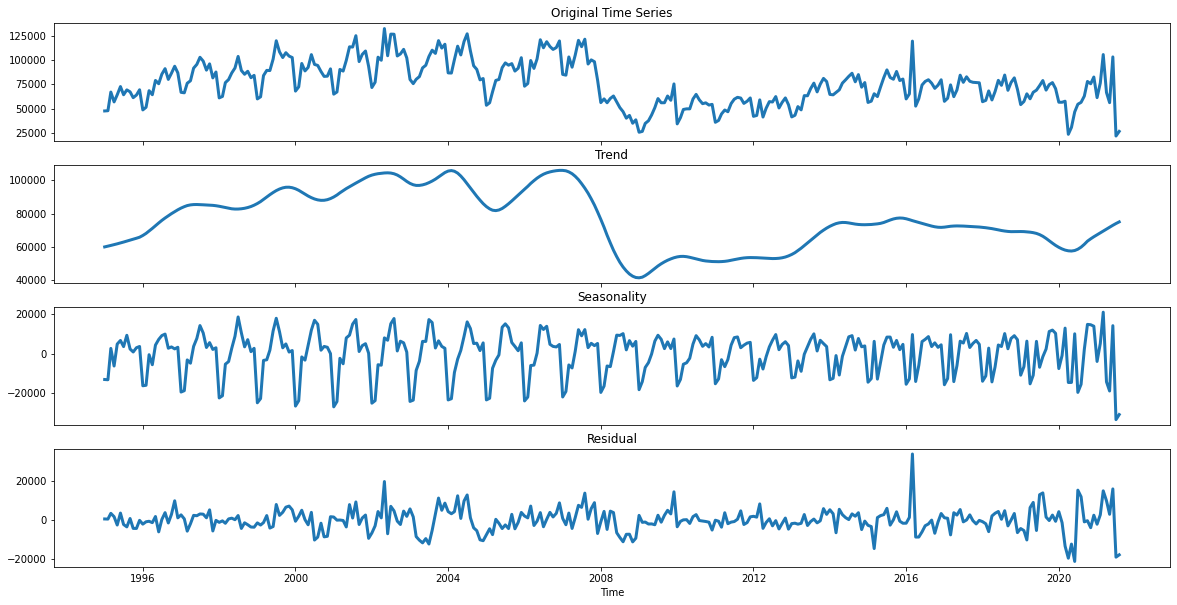

In [10]:
decomposer = TimeSeriesDecomposition(ts, decomposition="additive")
results = decomposer.decomposer()
fig = decomposer.plot()

## **Changepoint Detection using KATS**

**CUSUM Detector**

In [10]:
cumsum_detector = CUSUMDetector(ts)
changepoints = cumsum_detector.detector()
print(changepoints[0][0])

TimeSeriesChangePoint(start_time: 2007-12-01 00:00:00, end_time: 2007-12-01 00:00:00, confidence: 1.0)


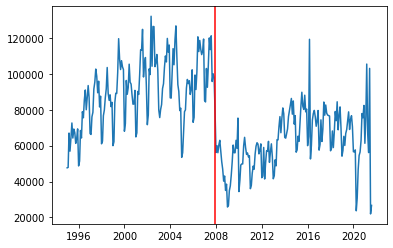

In [11]:
cumsum_detector.plot(changepoints)

**BOCPD Detector**

In [15]:
bocpd_detector = BOCPDetector(ts)

changepoints = bocpd_detector.detector(
    model=BOCPDModelType.NORMAL_KNOWN_MODEL, changepoint_prior=0.5, threshold = 0.45
)
for changepoint in changepoints:
    print(changepoint[0])

/usr/local/lib/python3.7/dist-packages/ax/core/parameter.py:468: UserWarning:

`sort_values` is not specified for `ChoiceParameter` "known_prec_multiplier". Defaulting to `True` for parameters of `ParameterType` FLOAT. To override this behavior (or avoid this warning), specify `sort_values` during `ChoiceParameter` construction.

/usr/local/lib/python3.7/dist-packages/ax/core/parameter.py:468: UserWarning:

`sort_values` is not specified for `ChoiceParameter` "cp_prior". Defaulting to `True` for parameters of `ParameterType` FLOAT. To override this behavior (or avoid this warning), specify `sort_values` during `ChoiceParameter` construction.



TimeSeriesChangePoint(start_time: 2002-12-01T00:00:00.000000000, end_time: 2002-12-01T00:00:00.000000000, confidence: 0.491238341164883)
TimeSeriesChangePoint(start_time: 2007-11-01T00:00:00.000000000, end_time: 2007-11-01T00:00:00.000000000, confidence: 0.5192437888674231)
TimeSeriesChangePoint(start_time: 2007-12-01T00:00:00.000000000, end_time: 2007-12-01T00:00:00.000000000, confidence: 0.556580350501221)
TimeSeriesChangePoint(start_time: 2020-03-01T00:00:00.000000000, end_time: 2020-03-01T00:00:00.000000000, confidence: 0.476728213540768)


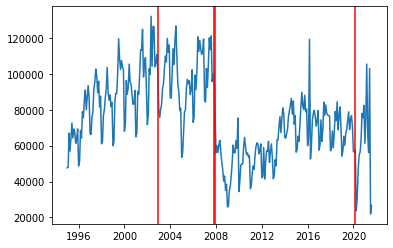

In [16]:
bocpd_detector.plot(changepoints)

## **Anomaly detection and removal**

In [18]:
outlier_detector = OutlierDetector(ts, "additive",iqr_mult=1)

In [19]:
outlier_detector.detector()
outliers = outlier_detector.outliers
outliers[0]

[Timestamp('1999-07-01 00:00:00'),
 Timestamp('2001-08-01 00:00:00'),
 Timestamp('2001-12-01 00:00:00'),
 Timestamp('2002-01-01 00:00:00'),
 Timestamp('2002-05-01 00:00:00'),
 Timestamp('2003-03-01 00:00:00'),
 Timestamp('2003-10-01 00:00:00'),
 Timestamp('2004-04-01 00:00:00'),
 Timestamp('2004-06-01 00:00:00'),
 Timestamp('2004-07-01 00:00:00'),
 Timestamp('2004-11-01 00:00:00'),
 Timestamp('2007-06-01 00:00:00'),
 Timestamp('2007-08-01 00:00:00'),
 Timestamp('2009-12-01 00:00:00'),
 Timestamp('2016-03-01 00:00:00'),
 Timestamp('2016-04-01 00:00:00'),
 Timestamp('2016-05-01 00:00:00'),
 Timestamp('2020-01-01 00:00:00'),
 Timestamp('2020-02-01 00:00:00'),
 Timestamp('2020-04-01 00:00:00'),
 Timestamp('2020-05-01 00:00:00'),
 Timestamp('2020-06-01 00:00:00'),
 Timestamp('2020-07-01 00:00:00'),
 Timestamp('2020-08-01 00:00:00'),
 Timestamp('2021-02-01 00:00:00')]

In [20]:
ts_day_outliers_interpolated = outlier_detector.remover(interpolate=True)

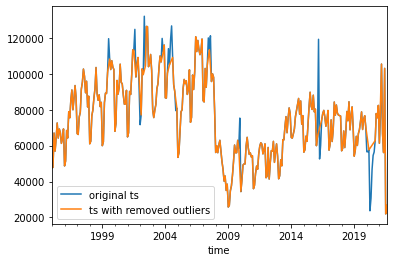

In [21]:
from matplotlib import pyplot as plt

ax = ts.to_dataframe().plot(x="time", y="value")
ts_day_outliers_interpolated.to_dataframe().plot(x="time", y="y_0", ax=ax)
plt.legend(labels=["original ts", "ts with removed outliers"])
plt.show()

In [14]:
result = mk.original_test(df['SalesVolume'])

In [15]:
print(result)

Mann_Kendall_Test(trend='decreasing', h=True, p=3.6439126382958875e-08, z=-5.50729407724912, Tau=-0.2063871473354232, s=-10534.0, var_s=3657864.6666666665, slope=-74.95314778804084, intercept=88103.52707219252)


In [11]:
print(result)

Mann_Kendall_Test(trend='decreasing', h=True, p=3.6439126382958875e-08, z=-5.50729407724912, Tau=-0.2063871473354232, s=-10534.0, var_s=3657864.6666666665, slope=-74.95314778804084, intercept=88103.52707219252)


In [24]:
sampledf_1 = df[df['Date']<'2007-11-01']

In [25]:
len(sampledf_1)

154

In [26]:
result = mk.original_test(sampledf_1['SalesVolume'])
print(result)

Mann_Kendall_Test(trend='increasing', h=True, p=6.963762899658832e-12, z=6.858395538350131, Tau=0.3727187844834904, s=4391.0, var_s=409717.0, slope=233.91666666666666, intercept=73276.375)


In [27]:
sampledf_2 = df[df['Date']>'2007-12-01']

In [28]:
result = mk.original_test(sampledf_2['SalesVolume'])
print(result)

Mann_Kendall_Test(trend='increasing', h=True, p=2.1803689964627893e-09, z=5.983765697627825, Tau=0.31490348645817745, s=4209.0, var_s=494541.0, slope=153.81557067271353, intercept=48627.53099017385)


# **Ruptures**

In [17]:
import matplotlib.pyplot as plt
import ruptures as rpt

In [26]:
# generate signal
n_samples, dim, sigma = 1000, 3, 4
n_bkps = 3  # number of breakpoints
signal, bkps = rpt.pw_constant(n_samples, dim, n_bkps, noise_std=sigma)

In [27]:
bkps

[256, 511, 765, 1000]

In [30]:
# detection
algo = rpt.Pelt(model="rbf").fit(np.array(df['SalesVolume']))
result = algo.predict(pen=10)

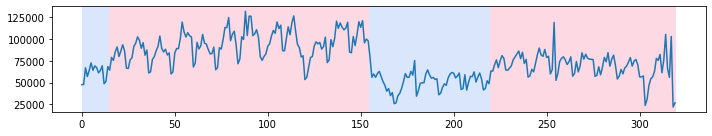

In [31]:
# display
rpt.display(np.array(df['SalesVolume']), result)
plt.show()